# 5: NPV Score Simulation

### Import relevant packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### NPV Buy and NPV Rent

In [2]:
def annuitaet_zahlung(kreditsumme: float, zins: float, tilgung: float) -> float:

    if kreditsumme <= 0:
        return 0.0
    if zins < 0 or tilgung < 0:
        raise ValueError("Zins und Tilgung müssen > 0 sein")

    return kreditsumme * (zins + tilgung)

def npv_kaufen(kaufpreis_pro_m2: float, zins: float, erwartete_rendite: float, tilgung: float, betrachtungszeitraum: int = 10, 
               wohnflaeche_m2: float = 80.0, eigenkapitalquote: float = 0.20, kaufnebenkosten_quote: float = 0.10, 
               verkaufskosten_quote: float = 0.05, instandhaltung_quote: float = 0.01, preissteigerung_immobilie: float = 0.02,
               steuersatz_veraeusserungsgewinn: float = 0.25) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Initialwerte
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)
    restschuld = darlehen

    # CF Betrachtung    
    cashflows = np.zeros(H + 1)
    # CF0
    cashflows[0] = -eigenkapital
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        zinsen_t = restschuld * zins
        tilgung_t = max(0.0, annuitaet - zinsen_t)
        tilgung_t = min(tilgung_t, restschuld)
        restschuld = max(0.0, restschuld - tilgung_t)
        instandhaltung_t = instandhaltung_quote * immowert_t
        cashflows[t] = -(zinsen_t + tilgung_t) - instandhaltung_t

    # CFH: CF bei Verkauf
    immowert_H = kaufpreis * (1.0 + preissteigerung_immobilie) ** H
    verkaufserloes_netto = immowert_H * (1.0 - verkaufskosten_quote)
    veraeusserungsgewinn = verkaufserloes_netto - anschaffungskosten

    steuer = 0.0
    if H < 10:
        steuer = max(0.0, veraeusserungsgewinn) * steuersatz_veraeusserungsgewinn

    cashflows[H] += (verkaufserloes_netto - steuer - restschuld)

    # Discounting Cash Flows
    diskontfaktoren = np.array([(1.0 + erwartete_rendite) ** t for t in range(H + 1)])
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_mieten_und_investieren(mietpreis_pro_m2: float, rendite_invest: float, erwartete_rendite: float, betrachtungszeitraum: int = 10, 
                               wohnflaeche_m2: float = 80.0, mietsteigerung: float = 0.02, 
                               # Buy Parameter: 
                               kaufpreis_pro_m2: float = 0.0, zins: float = 0.0, tilgung: float = 0.0, eigenkapitalquote: float = 0.20, 
                               kaufnebenkosten_quote: float = 0.10, instandhaltung_quote: float = 0.01, 
                               preissteigerung_immobilie: float = 0.02,
                               # Steuer (Endbesteuerung auf Gewinn)
                               kapitalertragssteuer_satz: float = 0.26375,) -> float:
    
    H = int(betrachtungszeitraum)
    if H <= 0:
        return np.nan

    # Budget = Annuität + Instandhaltungskosten 
    kaufpreis = float(kaufpreis_pro_m2) * float(wohnflaeche_m2)
    kaufnebenkosten = kaufpreis * kaufnebenkosten_quote
    anschaffungskosten = kaufpreis + kaufnebenkosten
    eigenkapital = eigenkapitalquote * anschaffungskosten
    darlehen = anschaffungskosten - eigenkapital
    annuitaet = annuitaet_zahlung(darlehen, zins, tilgung)

    # Initialmiete
    jahresmiete_0 = float(mietpreis_pro_m2) * float(wohnflaeche_m2) * 12.0

    # Initial-Investieren 
    vermoegen = float(eigenkapital)
    eingezahltes_geld = float(eigenkapital) # Summe der Einzahlungen ins Depot 

    # CF Betrachtung
    cashflows = np.zeros(H + 1, dtype=float)
    # CF0
    cashflows[0] = -float(eigenkapital)
    # CF1 bis CFH+1
    for t in range(1, H + 1):
        # budget_t = Annuität + Instandhaltungskosten
        immowert_t = kaufpreis * (1.0 + preissteigerung_immobilie) ** t
        instandhaltung_t = instandhaltung_quote * immowert_t
        budget_t = annuitaet + instandhaltung_t
        # Mietkosten + (Differenz) Investieren
        miete_t = jahresmiete_0 * (1.0 + mietsteigerung) ** (t - 1)
        sparen_t = budget_t - miete_t
        # Portfolioentwicklung
        vermoegen = vermoegen * (1.0 + rendite_invest) + sparen_t
        if sparen_t > 0:
            eingezahltes_geld += sparen_t

        # Budget als negativen Cashoutflow
        cashflows[t] = -budget_t

    # CFH: CF bei Verkauf
    gewinn = max(0.0, vermoegen - eingezahltes_geld)
    steuer = gewinn * float(kapitalertragssteuer_satz)
    vermoegen_netto = vermoegen - steuer

    cashflows[H] += vermoegen_netto
    # Discounting Cash Flows 
    diskontfaktoren = np.array([(1.0 + float(erwartete_rendite)) ** t for t in range(H + 1)], dtype=float)
    kapitalwert = float(np.sum(cashflows / diskontfaktoren))
    return kapitalwert

def npv_delta(kaufpreis_pro_m2: float, mietpreis_pro_m2: float, zins: float, tilgung: float, diskontsatz: float, rendite_invest: float,
    betrachtungszeitraum: int = 10, wohnflaeche_m2: float = 58.0, mietsteigerung: float = 0.02, kaufnebenkosten_quote: float = 0.10,
    eigenkapitalquote: float = 0.14, preissteigerung_immobilie: float = 0.03, instandhaltung_quote: float = 0.005,
    verkaufskosten_quote: float = 0.00, steuersatz_veraeusserungsgewinn: float = 0.25,) -> float:
   
    npv_buy = npv_kaufen(kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, erwartete_rendite=diskontsatz, 
                         betrachtungszeitraum=betrachtungszeitraum, wohnflaeche_m2=wohnflaeche_m2, 
                         kaufnebenkosten_quote=kaufnebenkosten_quote, eigenkapitalquote=eigenkapitalquote,
                         preissteigerung_immobilie=preissteigerung_immobilie, instandhaltung_quote=instandhaltung_quote, 
                         verkaufskosten_quote=verkaufskosten_quote, steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,)

    npv_rent_inv = npv_mieten_und_investieren(mietpreis_pro_m2=mietpreis_pro_m2, rendite_invest=rendite_invest, 
                                              erwartete_rendite=diskontsatz, betrachtungszeitraum=betrachtungszeitraum, 
                                              wohnflaeche_m2=wohnflaeche_m2, mietsteigerung=mietsteigerung, 
                                              kaufpreis_pro_m2=kaufpreis_pro_m2, zins=zins, tilgung=tilgung, 
                                              eigenkapitalquote=eigenkapitalquote, kaufnebenkosten_quote=kaufnebenkosten_quote, 
                                              instandhaltung_quote=instandhaltung_quote, 
                                              preissteigerung_immobilie=preissteigerung_immobilie,)

    npv_delta = npv_buy - npv_rent_inv
    return npv_delta

def rent_vs_buy_score(delta_npv: float, scale: float) -> float:

    if scale <= 0:
        raise ValueError("scale must be positive")
    return float(np.tanh(delta_npv / scale))

### Monte-Carlo-Simulation Score

Scale S (q90 von |ΔNPV/Kaufpreis|): 0.4532992358402772
Anteil |x| > 1: 0.1
Anteil |x| > 2: 0.004
Anteil |x| > 3: 0.0004


,kaufpreis_pro_m2,mietpreis_pro_m2,gross_yield,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv,delta_rel,score
4649,12125.733117,14.681301,0.018868,0.064142,0.018832,0.010553,0.042434,71.371334,0.113686,0.056967,-0.016861,0.008734,0.035277,0.269775,10,-760757.762784,-0.879052,-0.959473
3543,7759.990104,13.597470,0.021524,0.064551,0.039120,0.011729,0.083487,54.189022,0.096957,0.080272,-0.000484,0.013509,0.002435,0.270199,10,-350665.208267,-0.833912,-0.950762
3004,7653.675949,24.690310,0.042227,0.064392,0.022342,0.012117,0.088219,54.368758,0.079031,0.392413,-0.019478,0.014443,0.045801,0.270908,10,-331180.668109,-0.795876,-0.942025
905,6345.469029,14.406934,0.027146,0.066895,0.016690,0.017962,0.089246,84.491248,0.112851,0.178848,-0.012537,0.004222,0.023622,0.296347,10,-423307.176881,-0.789551,-0.940434
4636,10650.227126,29.649747,0.032785,0.059596,0.017611,0.014438,0.080430,114.471015,0.119479,0.171988,-0.012998,0.010609,0.049327,0.262229,10,-887031.549694,-0.727587,-0.922431
4791,11473.701529,35.057247,0.033070,0.065013,0.018478,0.012759,0.077369,61.647793,0.099324,0.124544,-0.016281,0.012212,0.020492,0.298081,10,-512571.992919,-0.724659,-0.921463
4925,6947.316566,14.551677,0.029378,0.064649,0.016505,0.010275,0.052604,64.438591,0.085351,0.103768,-0.015726,0.008502,0.004810,0.270044,10,-318977.202570,-0.712519,-0.917320
2109,8824.819334,14.015171,0.021933,0.053328,0.014554,0.012109,0.068621,117.275124,0.079807,0.065823,-0.012657,0.006886,0.045203,0.262790,10,-726919.876453,-0.702384,-0.913702
2082,8414.187372,16.167044,0.021136,0.053317,0.036566,0.028630,0.088137,94.546407,0.085971,0.227858,-0.014281,0.010396,0.031066,0.271928,10,-552885.190503,-0.694989,-0.910967
2964,13324.735512,40.000000,0.057599,0.068606,0.015489,0.017796,0.082531,37.618060,0.109032,0.398053,-0.001404,0.012467,0.042833,0.285662,10,-341438.870646,-0.681174,-0.905635


,kaufpreis_pro_m2,mietpreis_pro_m2,gross_yield,zins,tilgung,diskontsatz,rendite_invest,wohnflaeche_m2,kaufnebenkosten_quote,eigenkapitalquote,preissteigerung_immobilie,instandhaltung_quote,verkaufskosten_quote,steuersatz_veraeusserungsgewinn,betrachtungszeitraum,delta_npv,delta_rel,score
385,528.970093,6.0,0.047664,0.059666,0.011141,0.033393,0.076446,64.902933,0.083459,0.143135,0.047750,0.008976,0.030262,0.262258,10,35327.736344,1.029012,0.978881
4688,562.781227,6.0,0.037830,0.035012,0.011204,0.031504,0.081432,40.784979,0.088609,0.233940,0.039351,0.008141,0.026318,0.267718,10,24608.681429,1.072133,0.982508
2680,506.114899,6.0,0.034894,0.024726,0.035542,0.047797,0.060978,48.573340,0.109257,0.334380,0.052665,0.012459,0.018103,0.270598,10,27176.897237,1.105485,0.984883
2098,793.748599,6.0,0.032452,0.006392,0.011122,0.010021,0.056801,106.416032,0.087257,0.245280,0.045244,0.011647,0.019315,0.269216,10,94604.399102,1.120008,0.985815
2541,513.122786,6.0,0.045696,0.028235,0.039815,0.032809,0.072738,105.447553,0.080708,0.381700,0.033353,0.005784,0.023702,0.284329,10,60779.751835,1.123314,0.986019
1941,537.030269,6.0,0.038983,0.049530,0.021157,0.010668,0.083498,96.751988,0.073150,0.207068,0.031751,0.012120,0.025310,0.285437,10,58490.208524,1.125705,0.986164
1995,634.144937,6.0,0.070897,0.032476,0.017076,0.016584,0.062773,77.768254,0.084260,0.143090,0.050407,0.013032,0.035371,0.270805,10,56532.574538,1.146325,0.987360
3195,677.099904,6.0,0.029299,0.006521,0.025727,0.017342,0.038031,41.878663,0.097549,0.100344,0.048957,0.013776,0.039326,0.274516,10,34610.795095,1.220579,0.990875
1685,547.096823,6.0,0.045353,0.029600,0.029842,0.011991,0.053414,106.258930,0.069625,0.326032,0.047455,0.008986,0.045362,0.274132,10,81947.960693,1.409641,0.996027
2803,537.742959,6.0,0.070363,0.017162,0.015942,0.026685,0.026406,92.708722,0.062612,0.131950,0.051943,0.007114,0.010328,0.250123,10,72507.976721,1.454422,0.996738


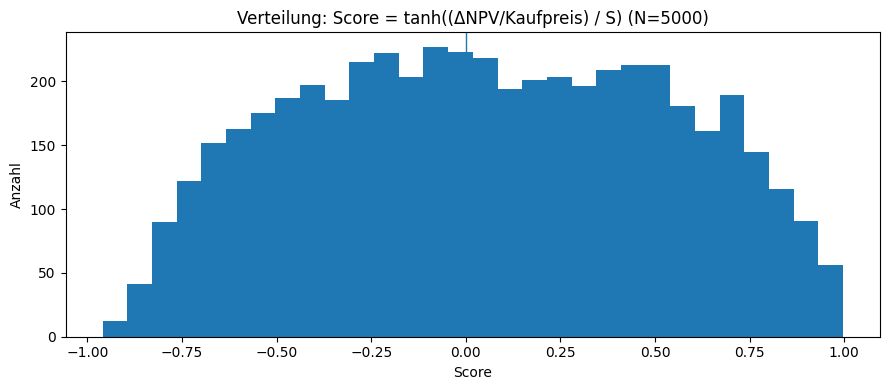

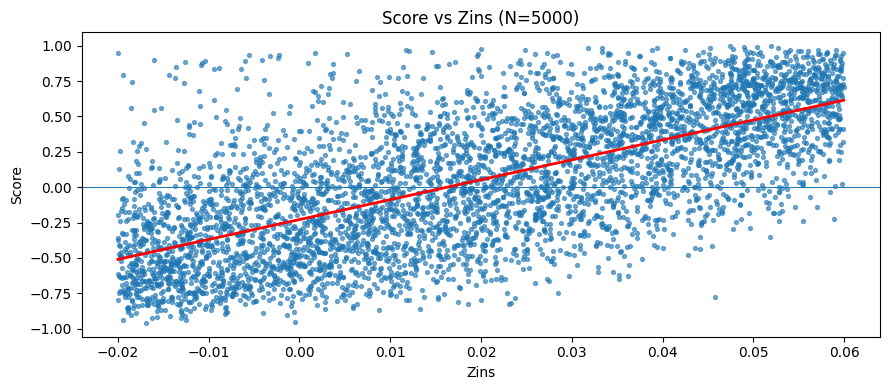

In [4]:
# -----------------------------
# Monte Carlo: bivariates Sampling über (Kaufpreis, Bruttomietrendite)
# -----------------------------

rng = np.random
N = 5000
H = 10

rows = []
for i in range(N):
    # ---------------------------------------------------------
    # 1) Realistisch gekoppelt: Preis + (Brutto-)Mietrendite -> Miete
    # ---------------------------------------------------------
    kaufpreis_pro_m2 = float(rng.uniform(500, 15000))

    # Bruttomietrendite p.a. (typisch grob 2% bis 7%; Modus ~3.5%)
    gross_yield = float(rng.triangular(left=0.015, mode=0.035, right=0.085))

    # Monatsmiete pro m² aus Yield abgeleitet
    mietpreis_pro_m2 = kaufpreis_pro_m2 * gross_yield / 12.0

    # kleine Streuung (lognormal), dann clippen auf plausible Mieten
    mietpreis_pro_m2 *= float(np.exp(rng.normal(0.0, 0.10)))  # ~10% Streuung
    mietpreis_pro_m2 = float(np.clip(mietpreis_pro_m2, 6.0, 40.0))

    # ---------------------------------------------------------
    # 2) Restliche Inputs (Ranges kannst du später feinjustieren)
    # ---------------------------------------------------------
    zins = float(rng.uniform(0.005, 0.07))
    tilgung = float(rng.uniform(0.01, 0.04))

    diskontsatz = float(rng.uniform(0.01, 0.06))
    rendite_invest = float(rng.uniform(0.02, 0.09))

    wohnflaeche_m2 = float(rng.uniform(35, 120))

    kaufnebenkosten_quote = float(rng.uniform(0.06, 0.12))
    eigenkapitalquote = float(rng.uniform(0.05, 0.40))
    preissteigerung_immobilie = float(rng.uniform(-0.02, 0.06))
    instandhaltung_quote = float(rng.uniform(0.003, 0.015))
    verkaufskosten_quote = float(rng.uniform(0.00, 0.05))
    steuersatz_veraeusserungsgewinn = float(rng.uniform(0.25, 0.30))

    # ---------------------------------------------------------
    # 3) ΔNPV berechnen
    # ---------------------------------------------------------
    try:
        delta = float(npv_delta(
            kaufpreis_pro_m2=kaufpreis_pro_m2,
            mietpreis_pro_m2=mietpreis_pro_m2,
            zins=zins,
            tilgung=tilgung,
            diskontsatz=diskontsatz,
            rendite_invest=rendite_invest,
            betrachtungszeitraum=H,
            wohnflaeche_m2=wohnflaeche_m2,
            mietsteigerung=0.02,
            kaufnebenkosten_quote=kaufnebenkosten_quote,
            eigenkapitalquote=eigenkapitalquote,
            preissteigerung_immobilie=preissteigerung_immobilie,
            instandhaltung_quote=instandhaltung_quote,
            verkaufskosten_quote=verkaufskosten_quote,
            steuersatz_veraeusserungsgewinn=steuersatz_veraeusserungsgewinn,
        ))
    except Exception:
        delta = np.nan

    rows.append({
        "kaufpreis_pro_m2": kaufpreis_pro_m2,
        "mietpreis_pro_m2": mietpreis_pro_m2,
        "gross_yield": gross_yield,

        "zins": zins,
        "tilgung": tilgung,
        "diskontsatz": diskontsatz,
        "rendite_invest": rendite_invest,
        "wohnflaeche_m2": wohnflaeche_m2,
        "kaufnebenkosten_quote": kaufnebenkosten_quote,
        "eigenkapitalquote": eigenkapitalquote,
        "preissteigerung_immobilie": preissteigerung_immobilie,
        "instandhaltung_quote": instandhaltung_quote,
        "verkaufskosten_quote": verkaufskosten_quote,
        "steuersatz_veraeusserungsgewinn": steuersatz_veraeusserungsgewinn,

        "betrachtungszeitraum": H,
        "delta_npv": delta,
    })

df_mc = pd.DataFrame(rows)

# -----------------------------
# 4) Score (robust, wenig Sättigung): relativ zum Kaufpreis skalieren
# -----------------------------
kaufpreis_total = df_mc["kaufpreis_pro_m2"] * df_mc["wohnflaeche_m2"]
df_mc["delta_rel"] = df_mc["delta_npv"] / kaufpreis_total

abs_rel = np.abs(df_mc["delta_rel"].dropna())

# robuster Scale: q90 von |Δ_rel|
S = float(abs_rel.quantile(0.90)) if len(abs_rel) else 1.0
if not np.isfinite(S) or S <= 0:
    S = 1.0

df_mc["score"] = np.tanh(df_mc["delta_rel"] / S)

print("Scale S (q90 von |ΔNPV/Kaufpreis|):", S)

x = df_mc["delta_rel"].dropna() / S
print("Anteil |x| > 1:", float((np.abs(x) > 1).mean()))
print("Anteil |x| > 2:", float((np.abs(x) > 2).mean()))
print("Anteil |x| > 3:", float((np.abs(x) > 3).mean()))

# -----------------------------
# 5) Checks / Outputs
# -----------------------------
display(df_mc.sort_values("score").head(10))
display(df_mc.sort_values("score").tail(10))

# Histogramm
plt.figure(figsize=(9,4))
plt.hist(df_mc["score"].dropna(), bins=30)
plt.axvline(0, linewidth=1)
plt.title("Verteilung: Score = tanh((ΔNPV/Kaufpreis) / S) (N=5000)")
plt.xlabel("Score")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

# Regression
plt.figure(figsize=(9,4))
plt.scatter(df_mc["preissteigerung_immobilie"], df_mc["score"], s=8, alpha=0.6)
plt.axhline(0, linewidth=0.75)
# Regressionslinie (linear)
x = df_mc["preissteigerung_immobilie"]
y = df_mc["score"]
m, b = np.polyfit(x.dropna(), y.loc[x.dropna().index], 1)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, m*xx + b, linewidth=2, color="red")
plt.title("Score vs Zins (N=5000)")
plt.xlabel("Zins")
plt.ylabel("Score")
plt.tight_layout()
plt.show()